# Uncovering Deterministic Behavior of Black Hole IGR J17091–3624: A Twin of GRS 1915+105

## Authors: Anindya Guria \& Banibrata Mukhopadhyay
## Accepted at Astrophysical Journal (ApJ); arXiv : 2411.17810

In [7]:
import os
import subprocess
import random
import time
import csv
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import seaborn as sns

# 3D plotting and Matplotlib tools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import patches as mpatches
from matplotlib import lines as mlines

# Scientific and statistical tools
from scipy.stats import entropy, variation, gaussian_kde
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from skimage.feature import peak_local_max
from skopt import gp_minimize
from skopt.space import Real

# Numerical and performance tools
from numba import njit, prange
from tqdm import tqdm

# Non-linear data analysis and other tools
import neurokit2 as nk
from kneed import KneeLocator
from nolitsa import d2, data, utils, surrogates
import colorednoise as cn


def rom(x):
    if type(x) == int:
        if x == 1:
            return "I"
        elif x == 2:
            return "II"
        elif x == 3:
            return "III"
        elif x == 4:
            return "IV"
        elif x == 5:
            return "V"
        elif x == 6:
            return "VI"
        elif x == 7:
            return "VII"
        elif x == 8:
            return "VIII"
        elif x == 9:
            return "IX"
        elif x == 10:
            return "X"
        elif x == 11:
            return "XI"
        elif x == 12:
            return "XII"
        elif x == 13:
            return "XIII"
        elif x == 14:
            return "XIV"
        elif x == 15:
            return "XV"
    return "Invalid input"


def save_array_to_text_file(directory, filename, data):
    """
    CREATES A TEXT FILE CONTAINING DATA IN THE MENTIONED DIRECTORY
    """
    # create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)   
    # join the directory and filename to get the full file path
    filepath = os.path.join(directory, filename)   
    # use numpy.savetxt to write the data to a text file
    np.savetxt(filepath, data, fmt='%f')   
    print(f"Array successfully saved to {filepath}")



# Denoising methods

In [3]:
'''
FILTERING
'''

def moving_average(x,w,nature="boxcar",sigma=1):
    def gaussian(x, mu, sig):
        return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
    if nature=="gaussian":
        b=np.arange(-w//2,w//2,step=1)
        g=gaussian(b,0,sigma)
        return np.convolve(x,g, 'same')/np.sum(g)
    else:
        b=(1/w)*np.ones(shape=w)
        return np.convolve(x,b, 'same')


@njit(parallel=True)
def non_local_means_1d(signal, window_size=5, search_size=10, h_factor=1.0, scale = False):
    """
    Numba-optimized Non-Local Means denoising for 1D signals with adaptive `h`
    and circular padding (periodic boundaries).
    
    Parameters:
    - signal: 1D numpy array containing the signal to be denoised.
    - window_size: Half-size of the neighborhood window used for computing similarity.
    - search_size: Half-size of the search window used for finding similar neighborhoods.
    - h_factor: A scaling factor for `h` to control the denoising strength.
    
    Returns:
    - Denoised 1D numpy array.
    """
    signal = signal.astype(np.float64)
    N = len(signal)

    # Manual padding to handle boundaries using circular wrapping
    pad_width = window_size + search_size
    padded_signal = np.zeros(N + 2 * pad_width, dtype=np.float64)

    # Fill the padded signal with circular wrapping
    padded_signal[pad_width:pad_width + N] = signal
    padded_signal[:pad_width] = signal[-pad_width:]
    padded_signal[-pad_width:] = signal[:pad_width]

    window_length = 2 * window_size + 1
    denoised_values = np.zeros(N, dtype=np.float64)  # Temporary array for each iteration's results

    # Main loop with Numba's prange for parallel processing
    for i in prange(N):
        idx = i + pad_width
        center_window = padded_signal[idx - window_size : idx + window_size + 1]

        # Compute the standard deviation of the center window
        std_dev = np.std(center_window)

        # PN expectation in centre window
        PN = np.sqrt(np.mean(center_window))

        # Set 'h' based on expected PN:
        h = h_factor * PN

        # Define search range
        search_start = max(pad_width, idx - search_size)
        search_end = min(idx + search_size + 1, len(padded_signal) - pad_width)
        search_indices = np.arange(search_start, search_end)

        # Initialize weights and distances
        weights = np.zeros(len(search_indices), dtype=np.float64)

        for j in range(len(search_indices)):
            neighbor_idx = search_indices[j]
            neighbor_window = padded_signal[neighbor_idx - window_size : neighbor_idx + window_size + 1]

            # Compute squared Euclidean distance
            dist2 = np.sum((center_window - neighbor_window) ** 2) / window_length

            # Compute weight
            weights[j] = np.exp(-dist2 / (h * h))

        # Normalize weights
        weight_sum = np.sum(weights)
        if weight_sum > 0:
            weights /= weight_sum
        else:
            weights[:] = 1.0 / len(weights)

        # Compute denoised value for the current point
        neighbor_values = padded_signal[search_indices]
        denoised_values[i] = np.sum(weights * neighbor_values)

    # Post-processing step outside of the parallel loop to normalize denoised values
    denoised_signal = denoised_values.copy()

    if scale == True:
        # Normalization: Scale denoised signal to match original signal characteristics
        deNoise_delta = max(denoised_signal) - min(denoised_signal)
        signal_delta = max(signal) - min(signal)
        signal_mean = np.mean(signal)
    
        # Adjust scale and mean
        if deNoise_delta != 0:  # To avoid division by zero
            denoised_signal -= np.mean(denoised_signal)
            denoised_signal *= (signal_delta / deNoise_delta)
            denoised_signal += signal_mean

    return denoised_signal



def adaptive_optimise(data, n_lims, k):
    """
    WRAPPER FUNCTION FOR PARAMETER OPTIMISATION OF ADAPTIVE FILTER. THE OPTIMAL WINDOW SIZE IS 
    TESTED 

    data   : 1d ndarray or list containing time series.
    n_lims : List of  window sizes to test is [2*n+1 for n in n_lims]
    k      : Polynomial order    
    """
    def adaptive_filter(data, n, k):
        """
        AN ADAPTIVE NON-LINEAR FILTER BY GAO ET AL. 2010. SEGMENTS TIME SERIES INTO LENGTHS OF 
        2N+1 AND FITS A POLYNOMIAL OF DEGREE K IN EACH SEGMENTS. FILTERED SERIES IS ESTIMATED BY
        EVALUATING THE POLYNOMIALS, AND WEIGHING THEM BY THE DISTANCE FROM CENTRES OF TWO 
        CONSECUTIVE SEGMENTS.

        data :    1d ndarray or list containing time series.
        n    :    2n+1 is the length of each segment.
        k    :    Order of the polynomial fitting to be used.

        RETURNS FILTERED ARRAY (not of the same length as input array).
        """
        polynomials = []
        length=len(data)
        num_segments = (length-1)//n-1
        #seg_index_list=[]
        seg_mid=[]                   
        i=0
        for i in range(num_segments):

            segment = data[n*i : n*i+2*n+1]
            seg_mid.append(n*i+n)
            x = np.arange(-n, n+1)
            y = segment        
            polynomial = np.polynomial.Polynomial.fit(x, y, k)        
            polynomials.append(polynomial)

        noise_less=[]

        for i in range(num_segments*n):
            seg_index= (i-1)//n - 1        
            try:
                dist1 = i-seg_mid[seg_index]
                polyvals_1=polynomials[seg_index](dist1)
                dist2 = i-seg_mid[seg_index+1]
                polyvals_2=polynomials[seg_index+1](dist2)            
                rec_val=(abs(dist2)*polyvals_1 + abs(dist1)*polyvals_2)/n
                noise_less.append(rec_val)
            except:
                try:
                    dist2 = i-seg_mid[seg_index+1]
                    polyvals_2=polynomials[seg_index+1](dist2)          
                    noise_less.append(polyvals_2)
                except:
                    dist1 = i-seg_mid[seg_index]
                    polyvals_1=polynomials[seg_index](dist1)
                    noise_less.append(polyvals_1)

        return np.array(noise_less)
    var_residue=[]
    n_range=range(n_lims[0],n_lims[1])
    for n in n_range:
        rectified=adaptive_filter(data,n,3)
        min_length = min(len(rectified), len(data))       
        rectified = rectified[2*n+1:min_length]
        data = data[2*n+1:min_length]
        residue=np.mean((data-rectified)**2)
        var_residue.append(residue)
    
    grad_residue=np.gradient(var_residue)    
    optimum_n=n_range[np.argmin(grad_residue)]
    
    optimised_filt=adaptive_filter(data,optimum_n,k)[2*optimum_n+1:]
    return(optimised_filt)
 
def Filter (signal,nature="NLM", n_pass = 1, std_dev=2, window_size=6, n_range=[2,20], k=3):
    """
    Wrapper function to handle all the denoising methods.
    """
    if nature=="boxcar":        
        while n_pass>0:
            signal = moving_average(signal,window_size, nature="boxcar")
            n_pass -= 1
        return signal
    elif nature=="gaussian":
        while n_pass>0:
            signal = moving_average(signal,window_size, nature="gaussian",sigma=std_dev)
            n_pass -= 1
        return signal
    elif nature=="adaptive":
        while n_pass>0:
            signal = adaptive_optimise(signal,n_range,k)
            n_pass -= 1
        return signal
    elif nature=="original":
        return signal
    else:
        while n_pass>0:
            signal = non_local_means_1d(signal,window_size = 500, search_size=3000, h_factor=std_dev, scale = True)
            n_pass -= 1
        return signal


## Loading IGR and GRS data...

In [4]:
diri_igr = "./igr_data/"
paths_igr = next(os.walk(diri_igr), (None, None, []))[2]
igr_data = dict()
for path in paths_igr:
    file = open(diri_igr+path,"r")
    data1 = file.readlines()
    file.close()
    data2 = []
    for d in data1:
        try:
            data2.append(float(d))
        except:
            continue
    data2 = np.array(data2)
    igr_data[path] = data2*0.125 # Converting to units of s-1
def igr (i):
    if i != 9:
        return igr_data["igr"+str(i)+".txt"]
    else:
        return igr_data["igr"+str(i)+".txt"][:-2000]

diri_grs = "./GRS_primary/"
paths_grs = next(os.walk(diri_grs), (None, None, []))[2]
grs_data = dict()
grs_names = ["alpha", "beta", "gamma", "delta", "chi", "mu", "nu", "phi", "theta", "lambda", "kappa", "rho"]

for path in paths_grs:
    file = open(diri_grs+path,"r")
    data1 = file.readlines()
    file.close()
    data2 = []
    for d in data1:
        try:
            data2.append(float(d))
        except:
            continue
    data2 = np.array(data2)
    grs_data[path] = data2*0.125 # Converting to units of s-1
    
def grs (name):
    return grs_data["GRS_"+ name +".txt"]

for i in range(1,10):
    print("IGR-{} : length = {}".format(i, len(igr(i))))

IGR-1 : length = 13424
IGR-2 : length = 26713
IGR-3 : length = 9217
IGR-4 : length = 21697
IGR-5 : length = 14561
IGR-6 : length = 9953
IGR-7 : length = 5169
IGR-8 : length = 13025
IGR-9 : length = 7240


## Optimal sensitivity parameter choice for NLM denoising

Directory 'NLM_sensitivity_plots' already exists.
PN = 3.7121000965550097
rms = 4.695136365247385
PN/rms ratio = 0.790626684249547
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

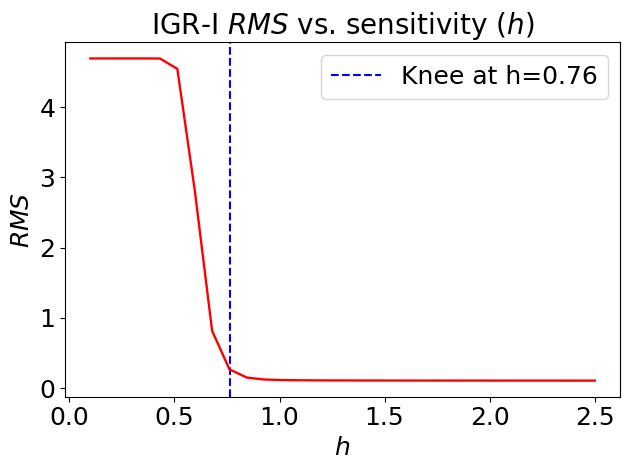

PN = 3.9942366295876686
rms = 5.288194124121709
PN/rms ratio = 0.7553120282344121
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

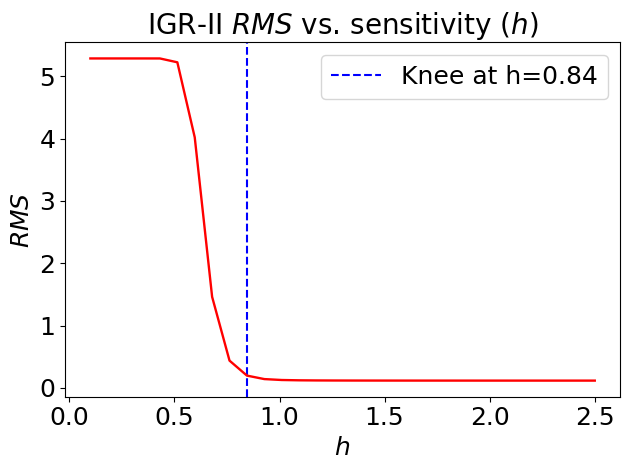

PN = 4.768763896672014
rms = 6.5107994507175295
PN/rms ratio = 0.73243907031209
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

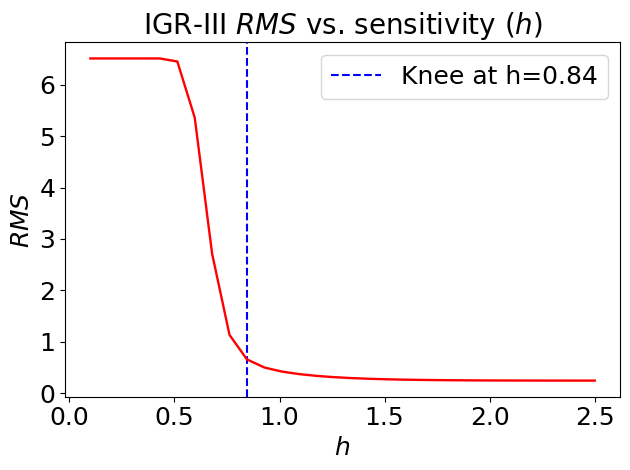

PN = 5.4310396349763765
rms = 9.471002732158802
PN/rms ratio = 0.5734387148401167
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

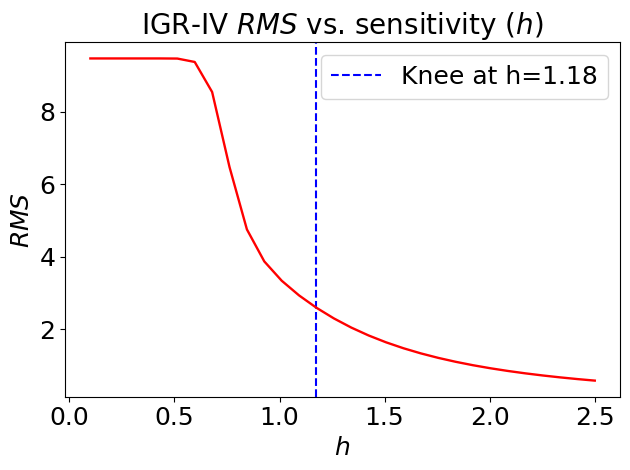

PN = 3.5188363460037086
rms = 7.548741166856763
PN/rms ratio = 0.4661487615250855
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

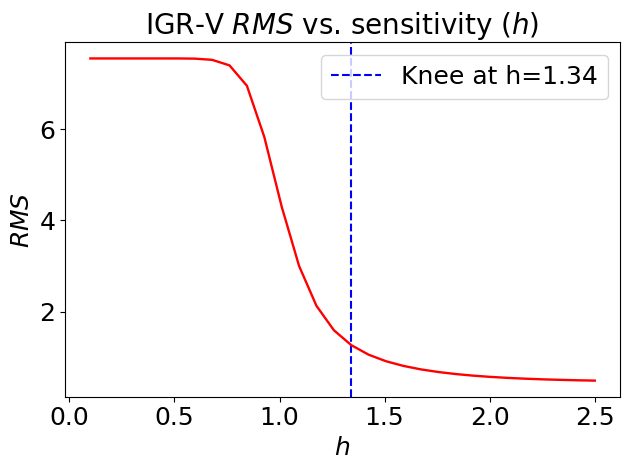

PN = 5.553555704600094
rms = 9.790520774339678
PN/rms ratio = 0.5672380287630465
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

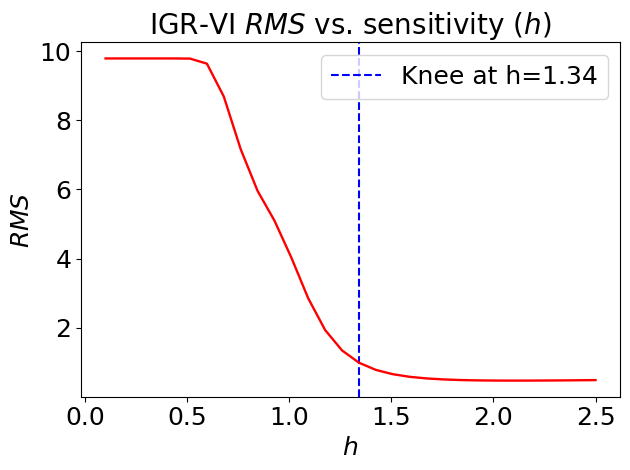

PN = 5.175025235820722
rms = 16.33073232788274
PN/rms ratio = 0.3168887427653808
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

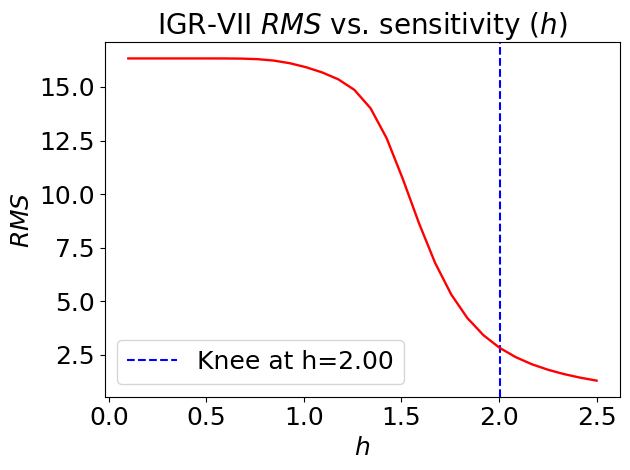

PN = 5.552924297941957
rms = 16.5469622995108
PN/rms ratio = 0.3355857224685963
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

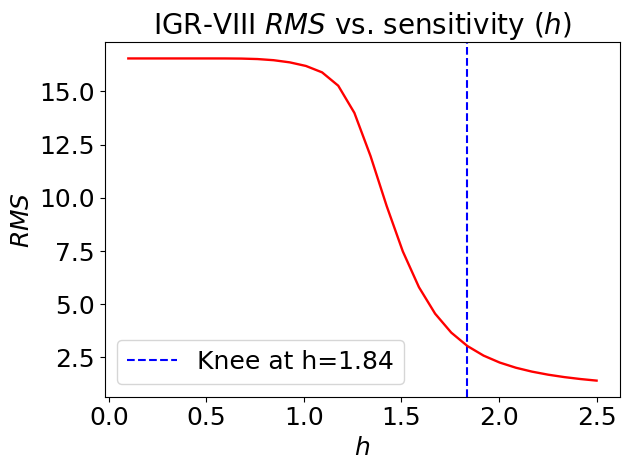

PN = 5.3360530355081295
rms = 8.420197865653602
PN/rms ratio = 0.633720622798444
0.100 0.183 0.266 0.348 0.431 0.514 0.597 0.679 0.762 0.845 0.928 1.010 1.093 1.176 1.259 1.341 1.424 1.507 1.590 1.672 1.755 1.838 1.921 2.003 2.086 2.169 2.252 2.334 2.417 2.500 

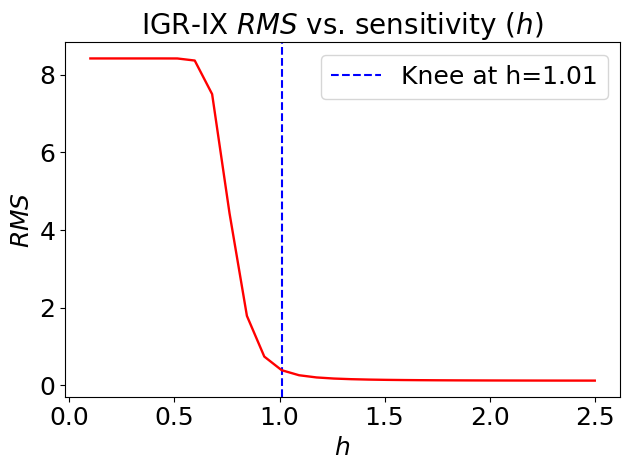

In [8]:
"""
This is not needed to be executed all the time. I have just printed and stored the h_knee values
in the next cell.
"""

# Directory to store the NLM sensitivity plots
directory_name = "NLM_sensitivity_plots"

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

#h_factors to use for NLM denoising
h_knee = np.zeros(shape = (9,)) 

for ind in range(1, 10):

    test_data = igr(ind)
    rms = np.std(test_data)
    S   = np.mean(test_data)
    PN = S**0.5
    PN_rms = PN/rms
    print("PN = {}".format(PN))
    print("rms = {}".format(rms))
    print("PN/rms ratio = {}".format(PN_rms))
    
    h_factors = np.linspace(0.1, 2.5, 30)
    rms_filt = []
    
    for h_fac in h_factors:
        print("{:.3f}".format(h_fac), end = " ")
        filt_data = non_local_means_1d(test_data, window_size=500, search_size=3000, h_factor =  h_fac)
        rms_filt.append(np.std(filt_data))
    
    knee_locator = KneeLocator(h_factors, rms_filt, curve='convex', direction='decreasing', online = True, S = 0.1)
    knee_point = knee_locator.knee
    h_knee[ind-1] = knee_point
    fig, ax = plt.subplots()
    
    ax.axvline(x=knee_point, color='b', linestyle='--', label=f'Knee at h={knee_point:.2f}')
    ax.plot(h_factors, rms_filt, color = "red", linewidth = 1.7)
    ax.set_xlabel(r"$h$", fontsize = 18)
    ax.set_ylabel(r"$RMS$", fontsize = 18)
    ax.set_title(r"IGR-{} $RMS$ vs. sensitivity $(h)$".format(rom(ind)), fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(prop={'size': 18})
    plt.tight_layout()
    plt.savefig("./{0}/IGR_{1}_NLM_sensitivity.png".format(directory_name, rom(ind)))
    plt.show()

In [5]:
#Storing the values for IGR data so that we don't have to calculate it everytime...
h_knee = [0.76206897, 0.84482759, 0.84482759, 1.17586207, 1.34137931, 1.34137931,
 2.00344828, 1.83793103, 1.01034483]

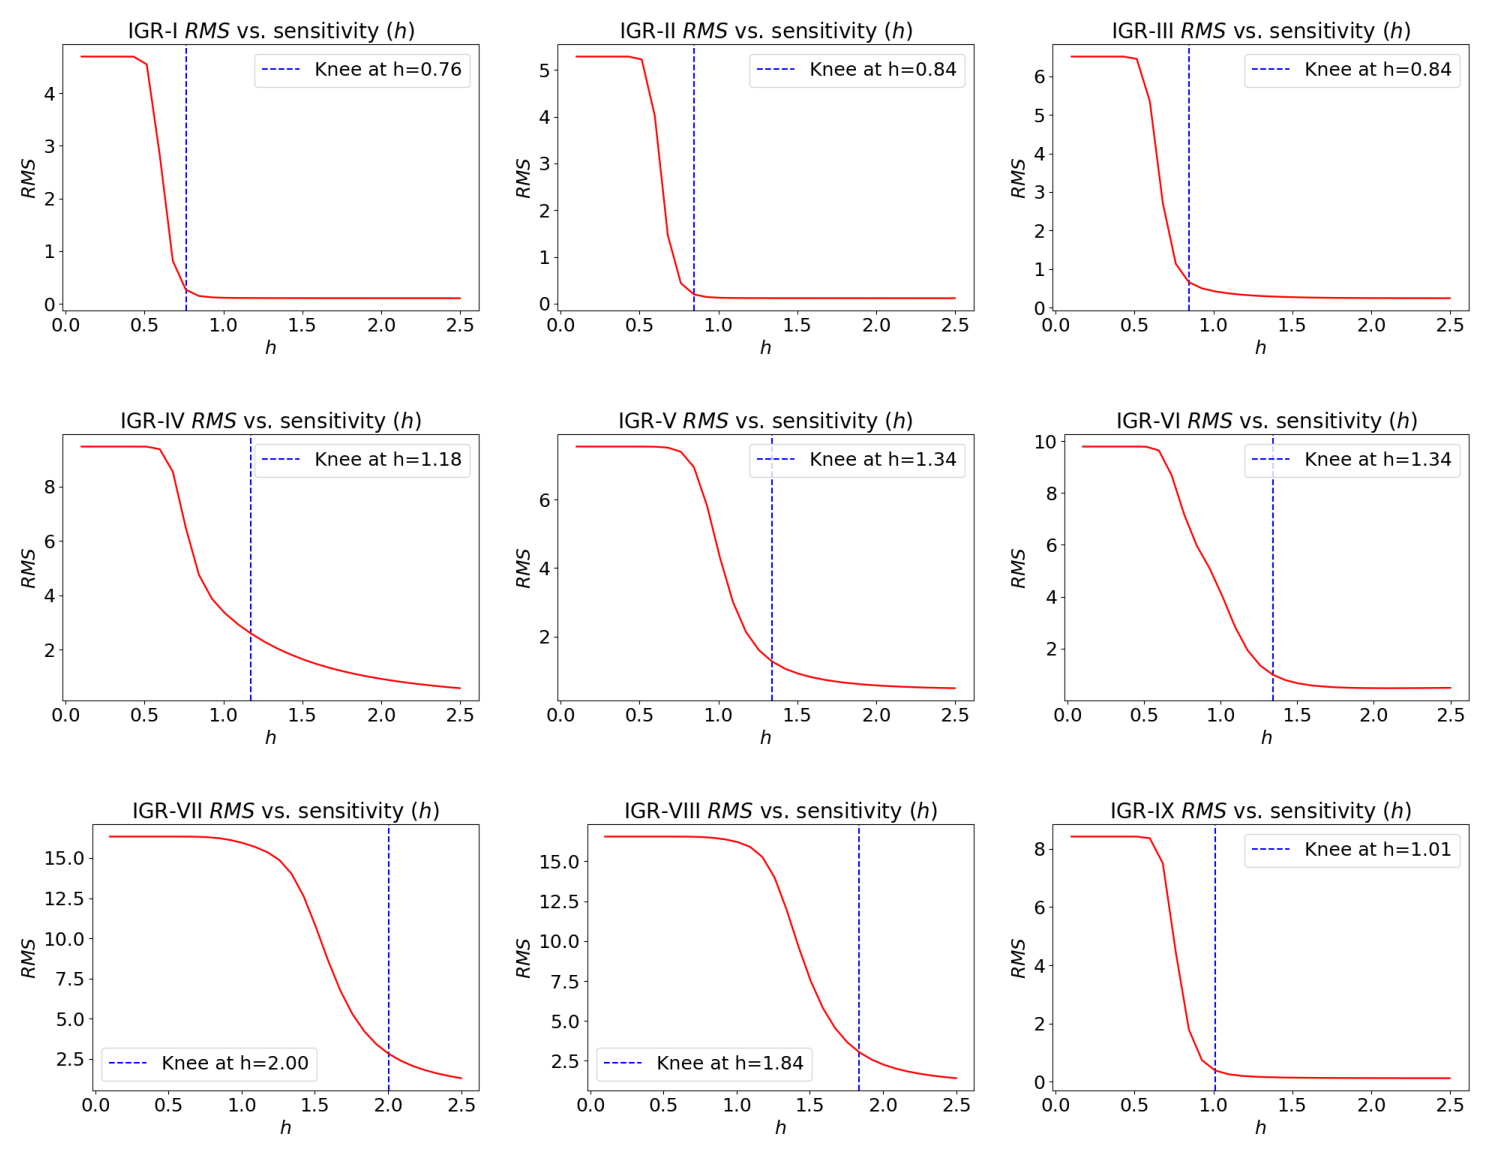

In [9]:
%matplotlib inline
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing the plots
plot_directory = "./NLM_sensitivity_plots"

# Get all the plot files from the directory
plot_files = glob.glob(os.path.join(plot_directory, "*.png"))  # Get all PNG files

  # Assuming plots are PNGs

# Sort the plot files by creation time
plot_files.sort(key=os.path.getctime)

# Number of plots we expect (3x3 grid)
expected_num_plots = 9

# Create a 3x3 grid layout for the plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Loop through all axes and plot the corresponding image
for ax, plot_file in zip(axes.flat, plot_files[:expected_num_plots]):
    # Load the image using PIL
    img = Image.open(plot_file)
    
    # Crop the top part of the image (e.g., remove 50 pixels from the top)
    width, height = img.size
    crop_top = 0  # Adjust this value as needed
    img_cropped = img.crop((0, crop_top, width, height))  # (left, top, right, bottom)
    
    # Display the cropped image
    ax.imshow(img_cropped)
    ax.axis('off')  # Hide the axis

# Adjust layout
plt.tight_layout()

plt.savefig(plot_directory+"/NLM_sensitivity.png", dpi = 500)

## IGR and GRS comparison plots

Directory 'IGR_GRS_comparison_plots' already exists.


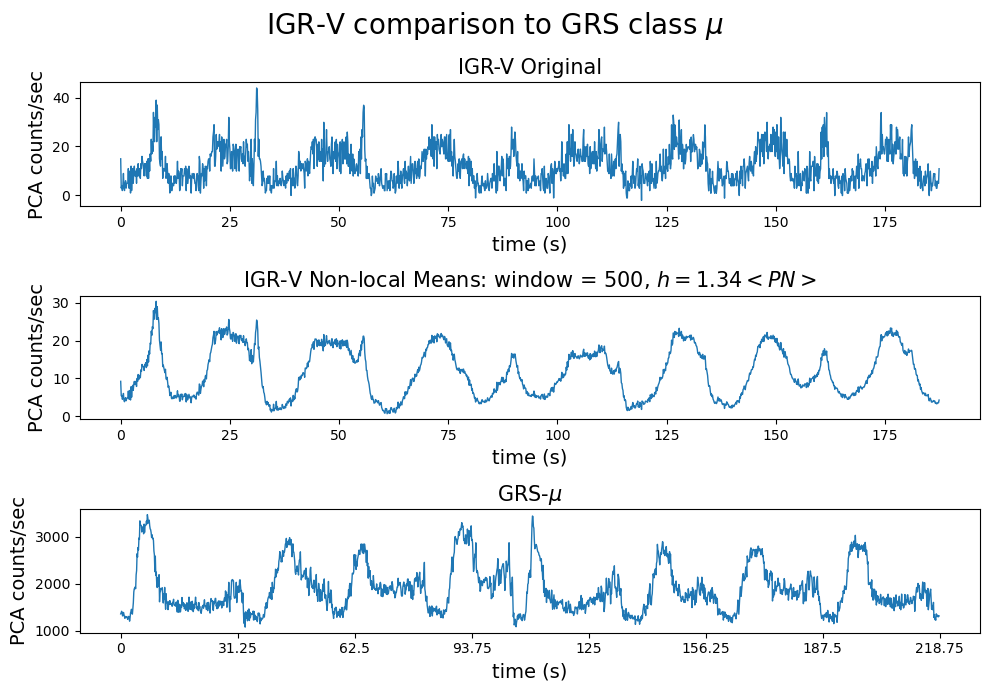

In [15]:
directory_name = "IGR_GRS_comparison_plots"

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

i=5
grs_nm = "mu"
test_data = igr(i)
comp_data = grs(grs_nm)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7))
sub_font = 15
plt.suptitle(r"IGR-{} comparison to GRS class $\{}$".format(rom(i), grs_nm), fontsize = 20)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 0.125))


ax1.set_title("IGR-{} Original".format(rom(i)), fontsize = sub_font)
ax1.plot(Filter(test_data,"original")[250:1750], linewidth = 1)
ax1.set_xlabel(r"time (s)", fontsize = 14)
ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_ylabel(r"PCA counts/sec", fontsize = 14)

# ax2.set_title("Boxcar convolution : window = 5", fontsize = sub_font)
# ax2.plot(Filter(test_data,"boxcar", window_size=5)[250:1950], linewidth = 1)

# ax3.set_title(r"Gaussian convolution: window = 5, $\sigma$ = 3", fontsize = sub_font)
# ax3.plot(Filter(test_data,"gaussian", window_size=5, std_dev = 3)[250:1950], linewidth = 1)

# ax4.set_title("Adaptive denoising: window = 20, k = 5", fontsize = sub_font)
# ax4.plot(Filter(test_data,"adaptive", window_size=5, n_range=[6,10], k=5)[170:1870], linewidth = 1)

ax2.set_title("IGR-{} Non-local Means: window = 500, $h = {:.2f}<PN>$".format(rom(i), h_knee[i-1]), fontsize = sub_font)
ax2.plot(Filter(test_data,"nlm", std_dev = h_knee[i-1]-0.1)[250:1750], linewidth = 1)#/Filter(test_data,"boxcar", window_size=6)[250:750])
ax2.set_xlabel(r"time (s)", fontsize = 14)
ax2.xaxis.set_major_formatter(ticks_x)
ax2.set_ylabel(r"PCA counts/sec", fontsize = 14)

ax3.set_title(r"GRS-$\{}$".format(grs_nm), fontsize = sub_font)
ax3.plot(Filter(comp_data,"original")[9500:11250], linewidth = 1)
ax3.set_xlabel(r"time (s)", fontsize = 14)
ax3.xaxis.set_major_formatter(ticks_x)
ax3.set_ylabel(r"PCA counts/sec", fontsize = 14)

fig.tight_layout()
# plt.savefig("IGR-V_GRS_mu_timeseries2.png", dpi = 500)
plt.savefig("./{0}/IGR_{1}_GRS_{2}.png".format(directory_name, rom(i), grs_nm))
plt.show()


In [11]:
"""
COLLECTING ALL AVAILABLE TIME SERIES DATA, APPLYING FILTERS AND ARRANGING THEM IN A 
NESTED DICTIONARY WITH CLASS INDEX AS THE OUTER DICT'S KEY AND FILTER NAME AS
INNER DICT'S KEY.
"""

data_dict = dict()

for i in tqdm(range(1,10)):
    
    data_IGR = igr(i)
    
    #Applying a local gaussian, boxcar moving average, NLM filter and an adaptive filter
    
    data_IGR_gaussian_filter = Filter(igr(i),"gaussian", window_size=9, std_dev=3)    
    
    data_IGR_boxcar_filter = Filter(igr(i),"boxcar", window_size=9)
    
    data_IGR_adaptive_filter = Filter(igr(i),"adaptive", n_range=[5,10], k=5)
      
    data_IGR_NLM_filter = Filter(igr(i),"nlm", std_dev = h_knee[i-1]-0.1)
        
    data_temp = {"original":data_IGR,
           "boxcar":data_IGR_boxcar_filter,
           "gaussian":data_IGR_gaussian_filter,
           "NLM":data_IGR_NLM_filter,
           "adaptive":data_IGR_adaptive_filter}
    
    data_dict["IGR-{}".format(rom(i))] = data_temp  #Arranging them together in a dictionary    
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.80s/it]


## SNR estimation

In [ ]:
def signaltonoise_dB(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def PN_by_rms(a):
    PN = np.sqrt(np.average(a))
    rms = np.std(a)
    return PN/rms
start = 1000
pl = 200
for i in range (1,10):
    data_org = data_dict["IGR-{}".format(rom(i))]["original"][start:start+pl]
    data_box = data_dict["IGR-{}".format(rom(i))]["boxcar"][start:start+pl]
    data_gau = data_dict["IGR-{}".format(rom(i))]["gaussian"][start:start+pl] 
    data_NLM = data_dict["IGR-{}".format(rom(i))]["NLM"][start:start+pl]
    data_ada = data_dict["IGR-{}".format(rom(i))]["adaptive"][start-95:start+pl-95]
    plt.plot(data_org)
    plt.plot(data_ada)
    plt.plot(data_NLM)
    # snr_org = PN_by_rms(data_org)#signaltonoise_dB(data_org)
    # snr_box = PN_by_rms(data_box)#signaltonoise_dB(data_box)
    # snr_gau = PN_by_rms(data_gau)#signaltonoise_dB(data_gau)
    # snr_NLM = PN_by_rms(data_NLM)#signaltonoise_dB(data_NLM)
    # snr_ada = PN_by_rms(data_ada)#signaltonoise_dB(data_ada)
    snr_org = signaltonoise_dB(data_org)
    snr_box = signaltonoise_dB(data_box)
    snr_gau = signaltonoise_dB(data_gau)
    snr_NLM = signaltonoise_dB(data_NLM)
    snr_ada = signaltonoise_dB(data_ada)
    
    print("{0}\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}\t{5:.2f}".format(i,snr_org,snr_box,
                                                                     snr_gau,snr_ada,snr_NLM))
    #print("{0:.2f}\t{1:0.2f}\t{2:0.2f}\t{3:-.2f}".format(s,rms,PN,PN_to_rms))

## Comparative plots of IGR light curves (w or w/o denoising)

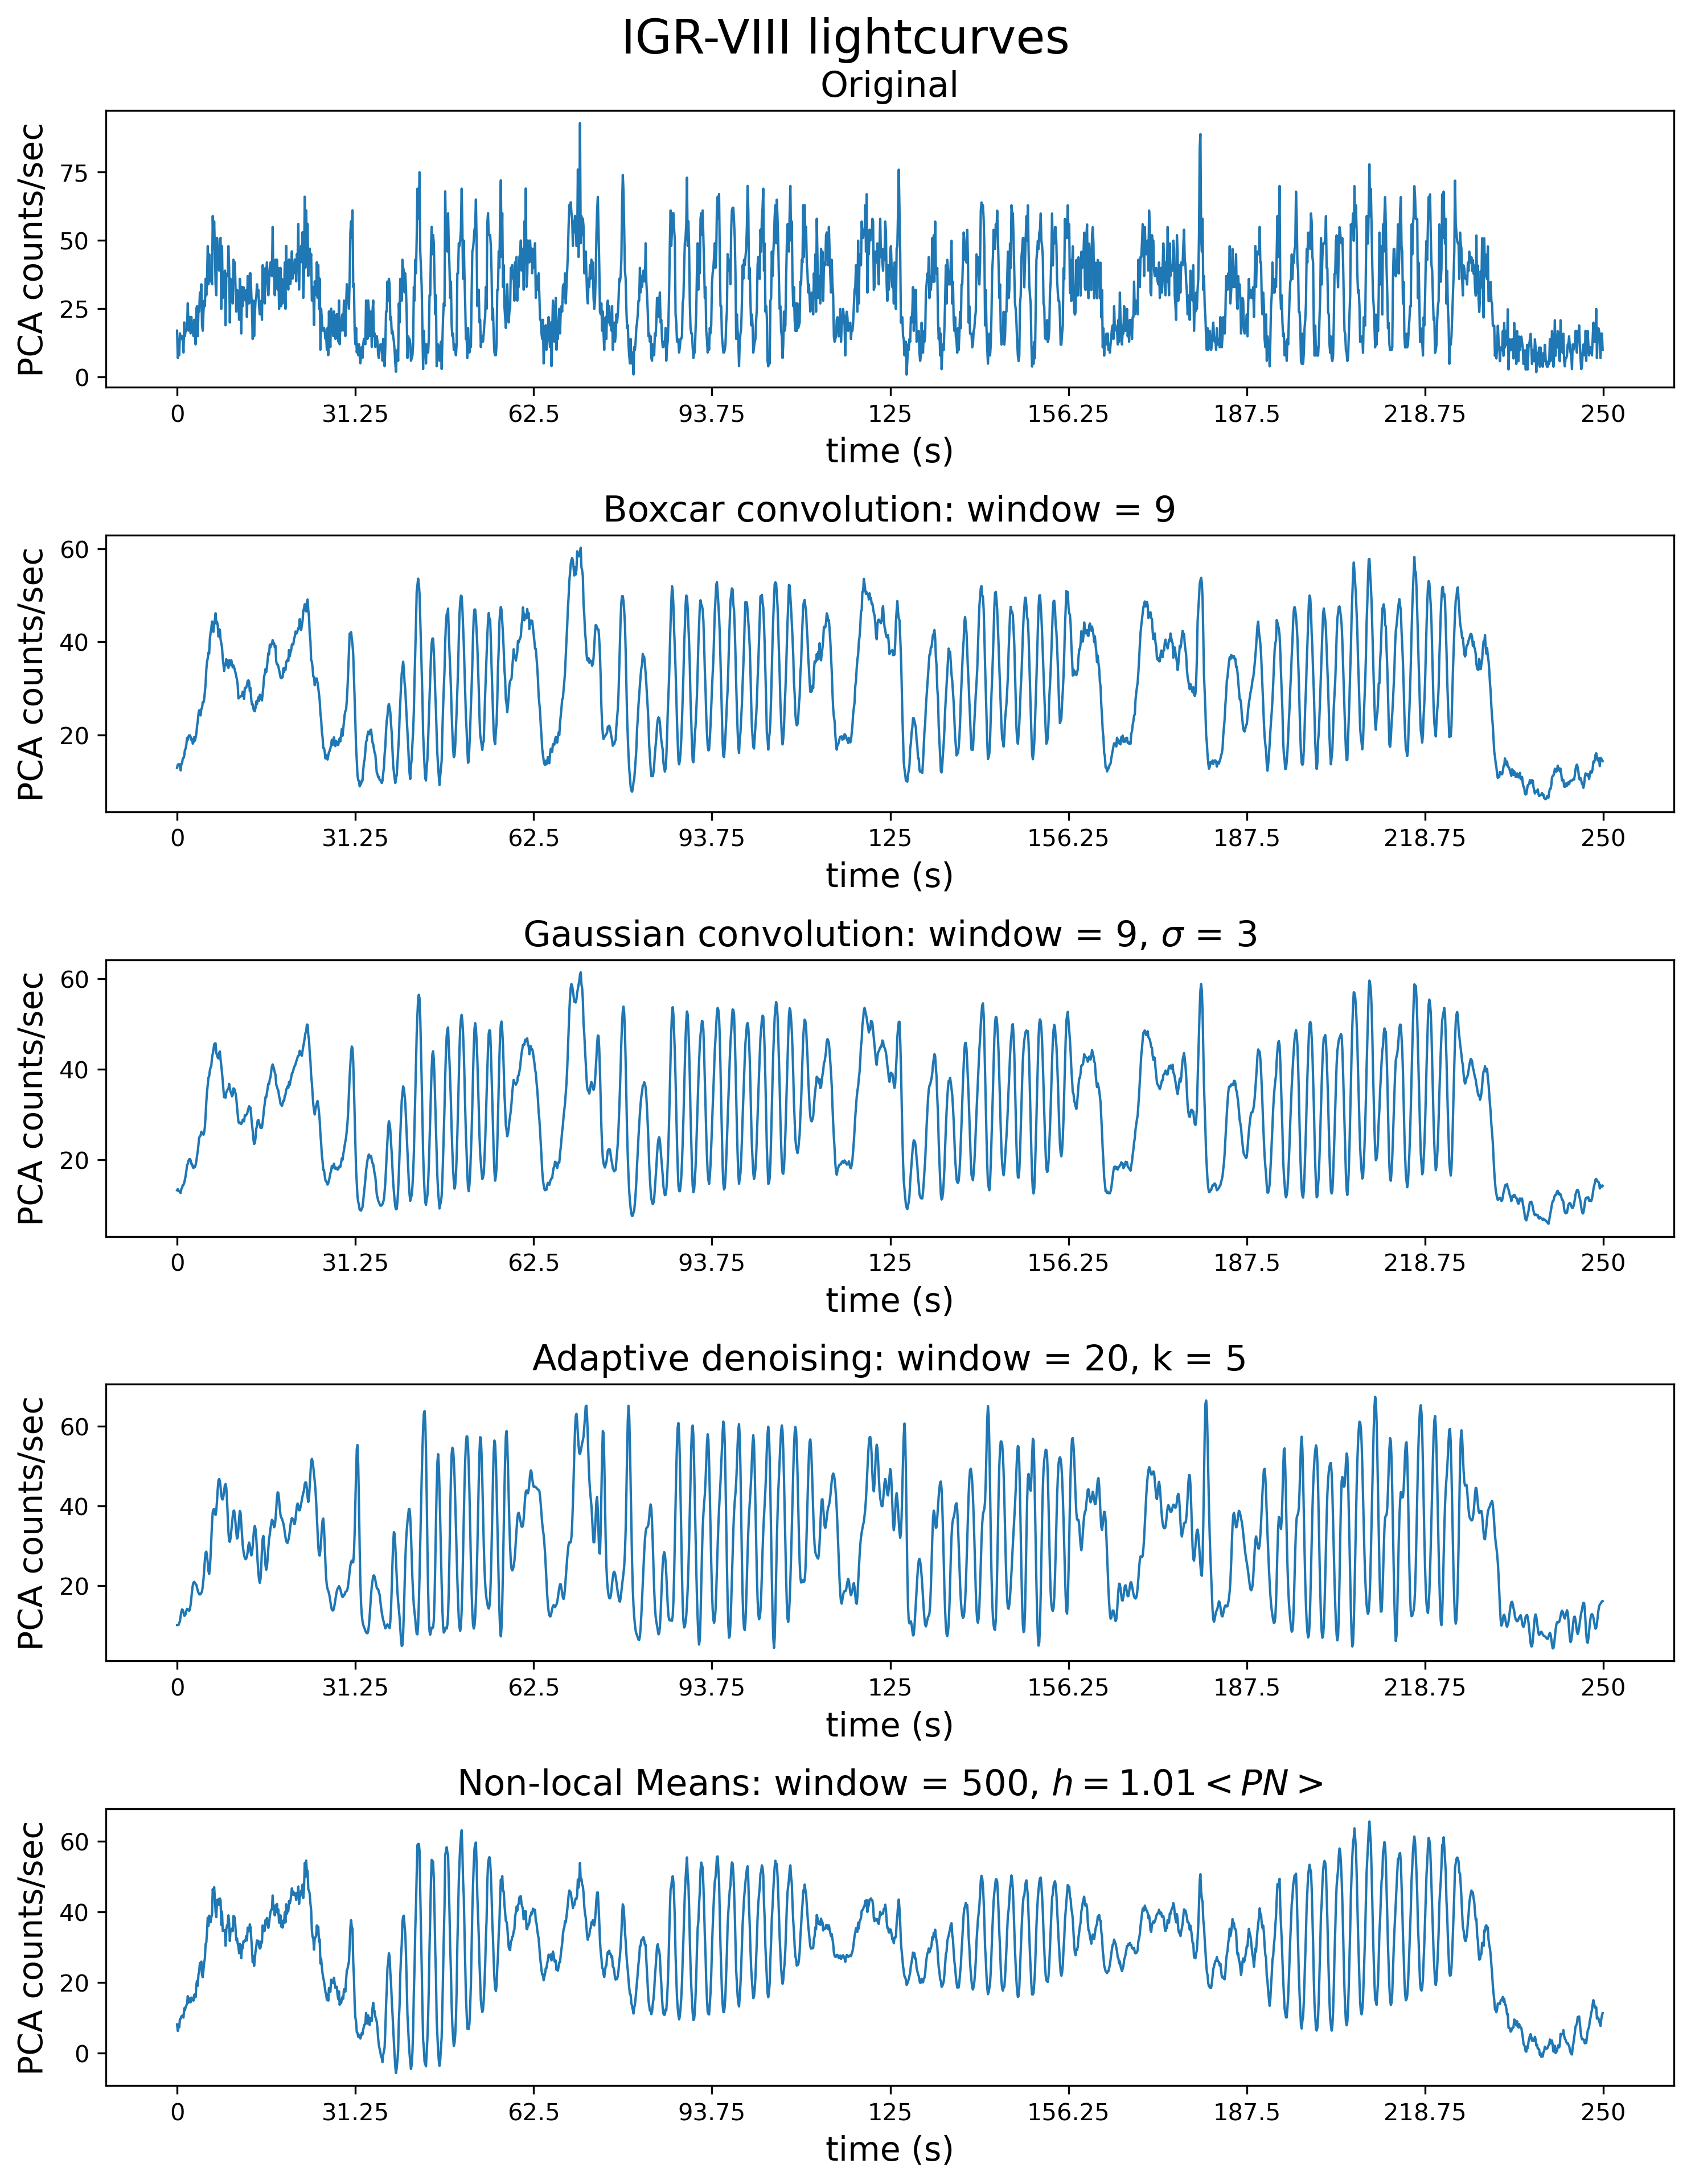

In [14]:
i = 8 # Choose which Class you want to plot
test_data = data_dict["IGR-{}".format(rom(i))]
# rms = np.std(test_data)
# S   = np.mean(test_data)
# PN = S**0.5
# PN_rms = PN/rms
# print("PN = {}".format(PN))
# print("rms = {}".format(rms))
# print("PN/rms ratio = {}".format(PN_rms))

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 13), dpi = 300)
sub_font = 15
plt.suptitle(r"IGR-{} lightcurves".format(rom(i)), fontsize = 20)

ax1.set_title("Original", fontsize = sub_font)
ax1.plot(test_data["original"][200:2200], linewidth = 1)
ax1.set_xlabel(r"time (s)", fontsize = 14)
ax1.xaxis.set_major_formatter(ticks_x)
ax1.set_ylabel(r"PCA counts/sec", fontsize = 14)

ax2.set_title("Boxcar convolution: window = 9", fontsize = sub_font)
ax2.plot(test_data["boxcar"][200:2200], linewidth = 1)
ax2.set_xlabel(r"time (s)", fontsize = 14)
ax2.xaxis.set_major_formatter(ticks_x)
ax2.set_ylabel(r"PCA counts/sec", fontsize = 14)

ax3.set_title(r"Gaussian convolution: window = 9, $\sigma$ = 3", fontsize = sub_font)
ax3.plot(test_data["gaussian"][200:2200], linewidth = 1)
ax3.set_xlabel(r"time (s)", fontsize = 14)
ax3.xaxis.set_major_formatter(ticks_x)
ax3.set_ylabel(r"PCA counts/sec", fontsize = 14)

ax4.set_title("Adaptive denoising: window = 20, k = 5", fontsize = sub_font)
ax4.plot(test_data["adaptive"][100:2100], linewidth = 1)
ax4.set_xlabel(r"time (s)", fontsize = 14)
ax4.xaxis.set_major_formatter(ticks_x)
ax4.set_ylabel(r"PCA counts/sec", fontsize = 14)

ax5.set_title(r"Non-local Means: window = 500, $h = {:.2f}<PN>$".format(h_knee[i]), fontsize = sub_font)
ax5.plot(test_data["NLM"][200:2200], linewidth = 1)#/Filter(test_data,"boxcar", window_size=6)[250:750])
ax5.set_xlabel(r"time (s)", fontsize = 14)
ax5.xaxis.set_major_formatter(ticks_x)
ax5.set_ylabel(r"PCA counts/sec", fontsize = 14)

fig.tight_layout()
plt.savefig("IGR-VIII_timeseries.png", dpi = 500)
plt.show()

## Power Spectral Density (PSD) analysis

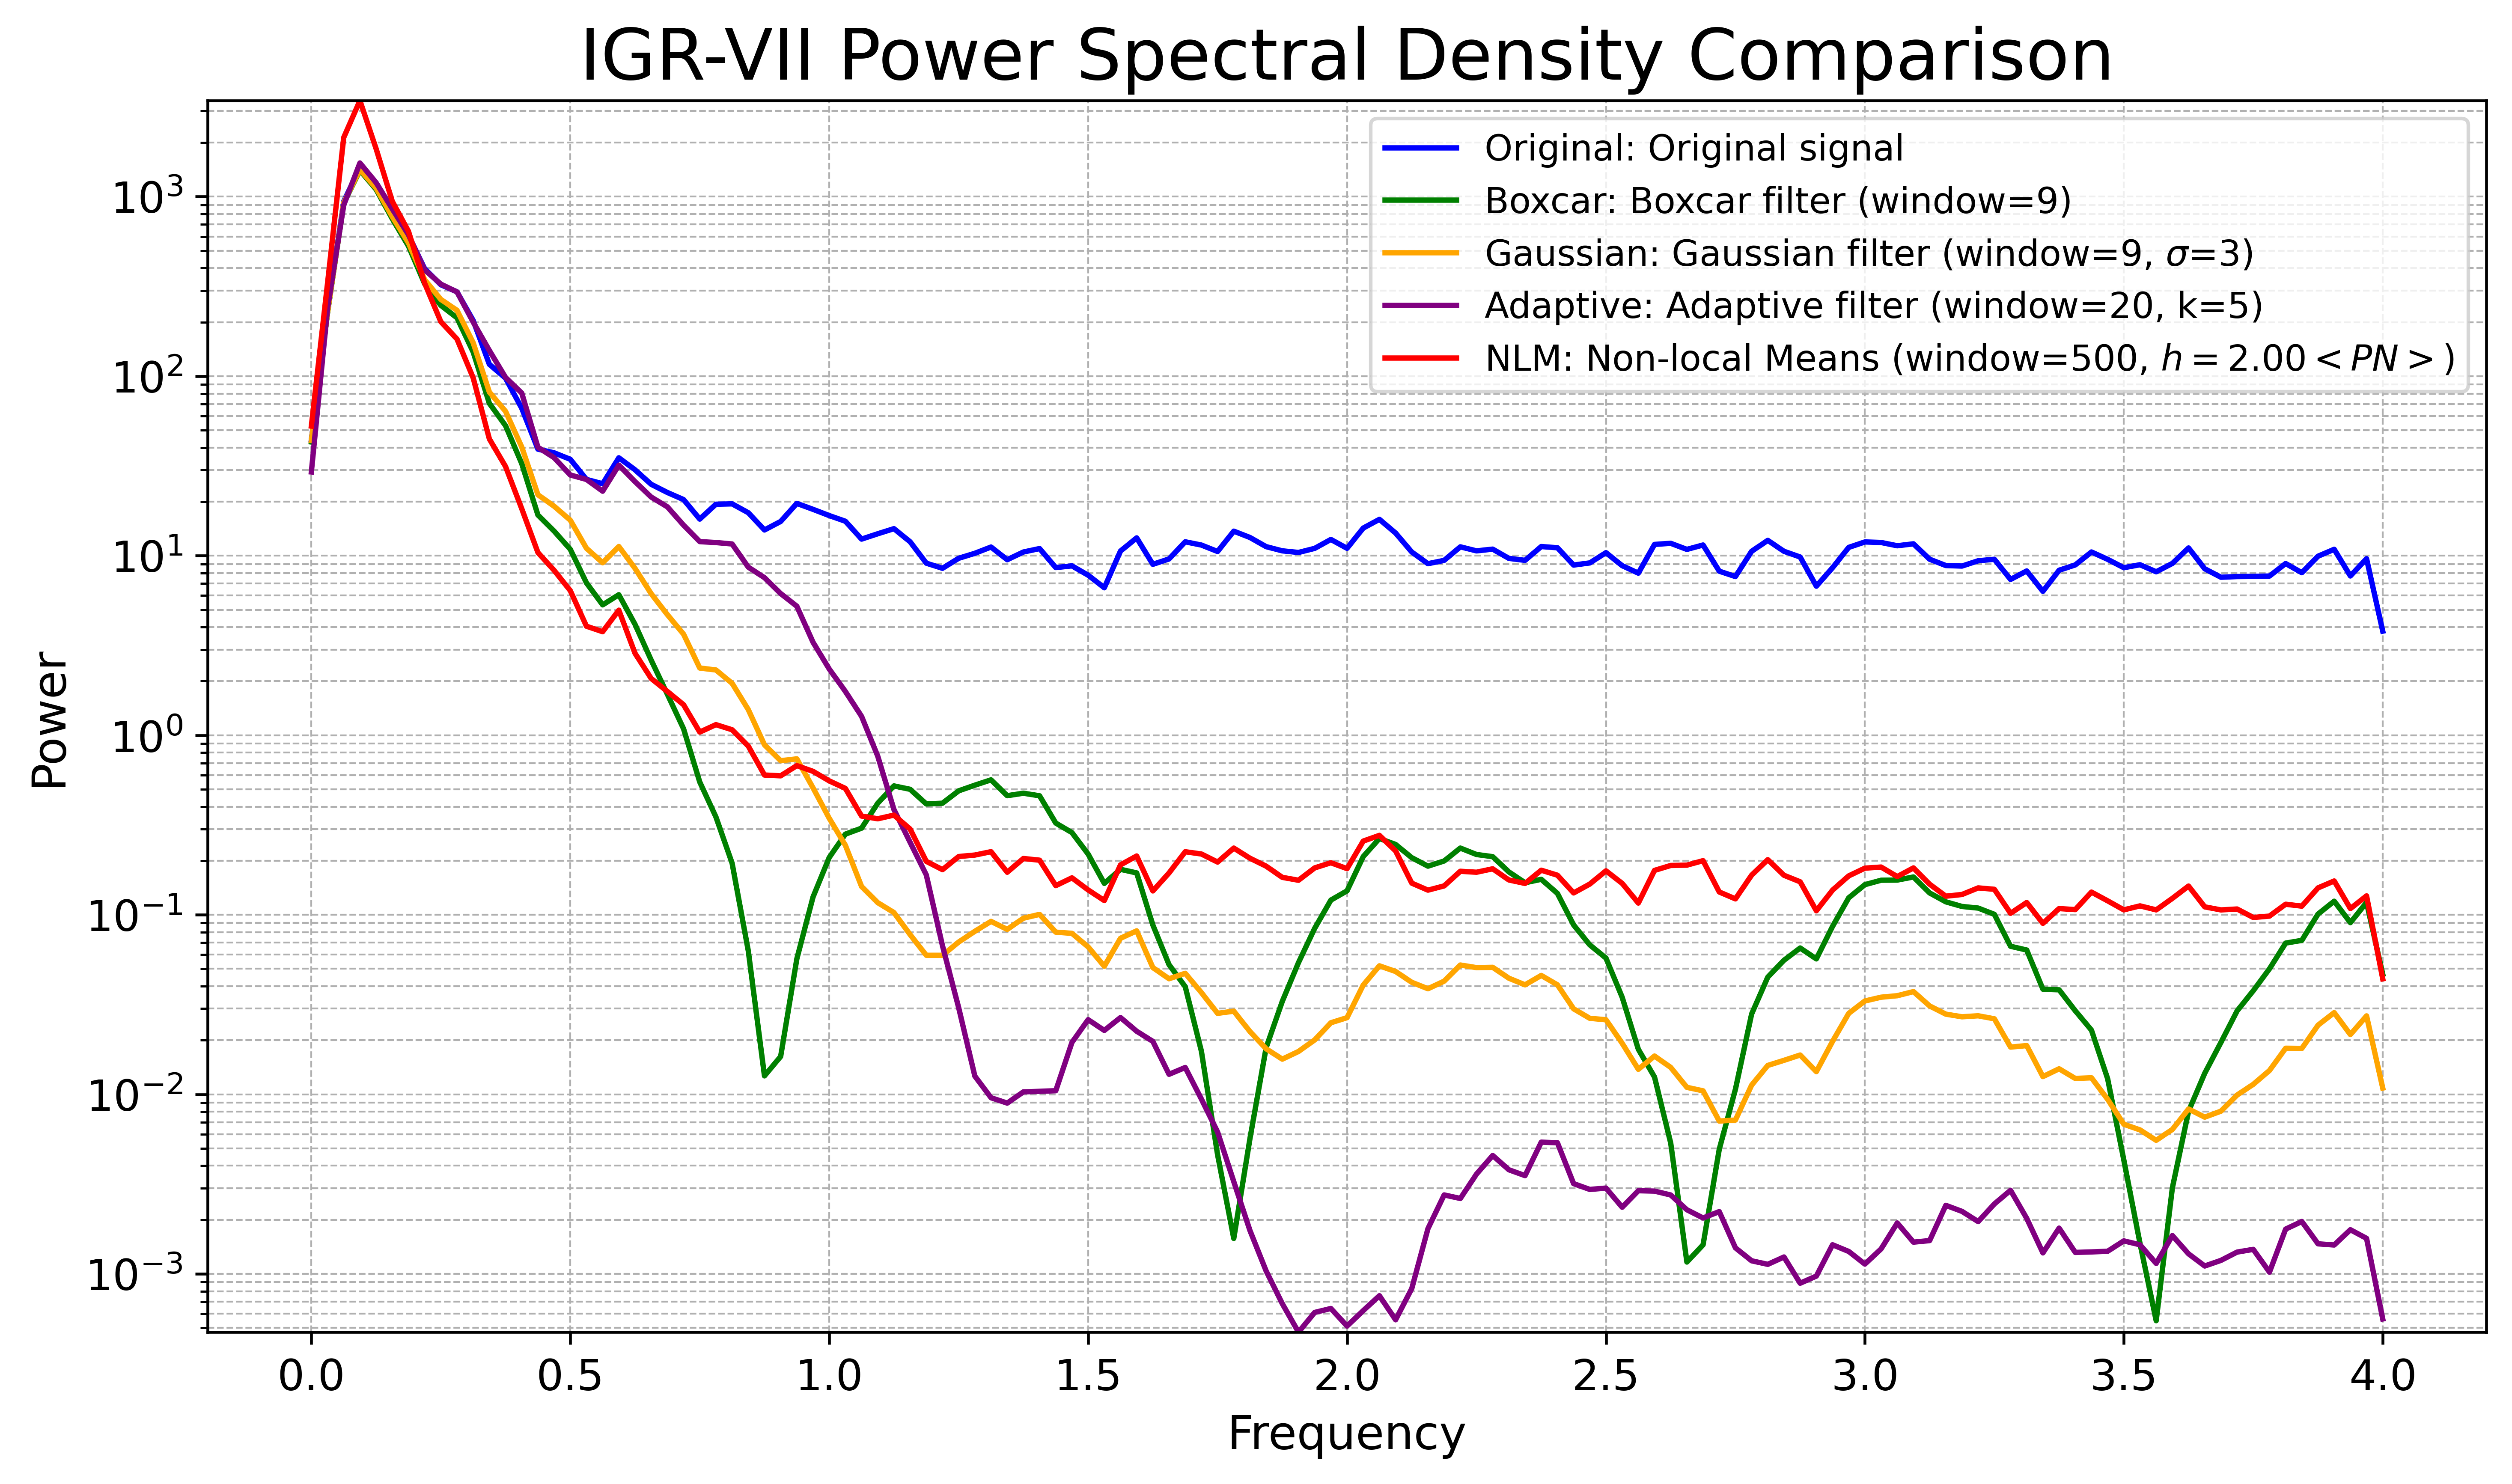

In [81]:

import matplotlib.pyplot as plt
from scipy.signal import welch

i = 7 # Index of IGR class that you want to check PSD of.
test_data = data_dict["IGR-{}".format(rom(i))]
fs = 1/0.125  # Sampling frequency

# Remove the DC component (mean) from each signal
signals = {
    "Original": test_data["original"] - np.mean(test_data["original"]),
    "Boxcar": test_data["boxcar"] - np.mean(test_data["boxcar"]),
    "Gaussian": test_data["gaussian"] - np.mean(test_data["gaussian"]),
    "Adaptive": test_data["adaptive"][200:] - np.mean(test_data["adaptive"][200:]),
    "NLM": test_data["NLM"] - np.mean(test_data["NLM"])
}

# Descriptions for each filter
descriptions = {
    "Original": "Original signal",
    "Boxcar": "Boxcar filter (window=9)",
    "Gaussian": r"Gaussian filter (window=9, $\sigma$=3)",
    "Adaptive": "Adaptive filter (window=20, k=5)",
    "NLM": r"Non-local Means (window=500, $h={:.2f}<PN>$)".format(h_knee[i-1])
}

# Compute PSDs for each signal and find global min/max for consistent scaling
psd_data = {}
global_min_psd, global_max_psd = float('inf'), float('-inf')
for key, signal in signals.items():
    frequencies, psd = welch(signal, fs=fs)
    psd_data[key] = (frequencies, psd)
    global_min_psd = min(global_min_psd, np.min(psd))
    global_max_psd = max(global_max_psd, np.max(psd))

# Set up a single plot for all PSDs
plt.figure(figsize=(10, 6), dpi=600)
plt.title(r"IGR-{} Power Spectral Density Comparison".format(rom(i)), fontsize=20)

# Define colors for each type of signal
colors = {
    "Original": "blue",
    "Boxcar": "green",
    "Gaussian": "orange",
    "Adaptive": "purple",
    "NLM": "red"
}

# Plot each PSD on the same axes with different colors and detailed legend
for key, (frequencies, psd) in psd_data.items():
    plt.semilogy(frequencies, psd, label=f"{key}: {descriptions[key]}", color=colors[key], linewidth=1.5)

# Customize plot with labels, grid, limits, and legend
plt.xlabel("Frequency", fontsize=13)
plt.ylabel("Power", fontsize=13)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(global_min_psd, global_max_psd)
plt.legend(fontsize=10, loc='best')  # Legend with descriptions
plt.tight_layout()
plt.show()


# S/NS Classification algorithms

This section is meant to test out all the different available algorithms (CD, SVD and PCA) on 
artificial/ original/ noised/ denoised time series data.

## Correlation Dimension method

Here I have used the very fast fortran code by my professor Banibrata Mukhopadhyay to compute
the embedding dimension versus correlation dimension. It also produces error bounds. 

NOTE : SINCE THE FORTRAN EXE INPUTS THE TIME SERIES AS A TEXT FILE, WE FIRST MAKE A TEMPORARY
TEXT FILE CONTAINING THE INPUT DATA IN A SUITABLE FORMAT.

In [11]:
def CD_ED(data,code,max_ED=10):
    
    '''
    Output is a 2d ndarray. For each row:
    1st element: Embedding dimension
    2nd element: Correlation dimension
    3rd element: CD Upper error bound
    4th element: CD Lower error bound    
    '''
    #Specifying the directory of dim2_mute executable.
    diri="."
    #Creating a temporary file
    
    filein='input_temp'+code+'.txt'
    save_array_to_text_file(diri, filein, data)    
    #other inputs
    min_Embed_Dimension = 1
    max_Embed_Dimension = max_ED    
    data_length=data.shape[0]
    
    delay,_= nk.complexity_delay(data, delay_max=1000,
                        method="fraser1986",algorithm = 'first local minimum (corrected)')
    print("Running...2")
    #Using 15% of the total data length for number of centres
    center_num = int(0.15*data.shape[0])    
    convolve_ask="no"
    
    # Convert input values to bytes
    input_bytes = f"{filein}\n{data_length}\n{min_Embed_Dimension}\n{max_Embed_Dimension}\n{delay}\n{center_num}\n{convolve_ask}\n".encode()
    
    # Run the Fortran code and provide inputs    
    subprocess.run([diri+r"/"+r'dim2_mute'], cwd=diri,input=input_bytes)
    print("Ran")
    # open the output file from the dim2_mute executable and collect the CD_ED data
    output_file=open(diri+r'/Out_'+filein,"r")
    output=output_file.readlines()
    output_file.close()
    
    #Deleting the output files to save disc space
    os.remove(diri+r'/Des_Out_'+filein)
    os.remove(diri+r'/Out_'+filein)
    os.remove(diri+r'/'+filein)
    
    output=[line.split() for line in output]
    output=np.array(output,dtype=float)
    output=output[~np.isnan(output).any(axis=1)]
    print("Done!!!  >>>",code)
    return output
#########################################################################################



In [ ]:
"""
APPLYING CORRELATION DIMENSION AND SURROGATE ANALYSIS METHOD

MULTI-THREADED APPROACH
"""


def process_path_filter(data_in,ID):
    f= open('./'+ID+'.csv', 'w', encoding='UTF8')
    
    writer = csv.writer(f)
    
    surr=[surrogates.iaaft(data_in)[0] for i in range(19)]
    #print(surr)
    dd=CD_ED(data_in,code=ID,max_ED=20)[:,1]   

    writer.writerow(dd)
    
    for i in range(len(surr)):
        surr_dat=surr[i]        
        surr_CD=CD_ED(surr_dat,code=ID+"surr"+str(i),max_ED=25)[:,1]
        writer.writerow(surr_CD)

    f.close()
    print("ID: ",ID," stored!!!")
num_cores = multiprocessing.cpu_count()
print(num_cores)
pool = multiprocessing.Pool(processes=num_cores)
for i in range(1,10):    
    pool.apply_async(process_path_filter, (Filter(igr(i),"original"),str(i)+"_org"))
    # process_path_filter(Filter(igr(i),"original"),str(i)+"_org")
    pool.apply_async(process_path_filter, (Filter(igr(i),"boxcar", window_size=9),str(i)+"_boxFilt"))
    pool.apply_async(process_path_filter, (Filter(igr(i),"gaussian", window_size=9, std_dev=3) ,str(i)+"_gauFilt"))
    pool.apply_async(process_path_filter, (Filter(igr(i),"nlm", std_dev = h_knee[i-1]-0.1) ,str(i)+"_nlmFilt"))
    pool.apply_async(process_path_filter, (Filter(igr(i),"adaptive", n_range=[5,10], k=5) ,str(i)+"_adaFilt"))

pool.close()

pool.join()
# process_path_filter(Filter(igr(6),"nlm", std_dev = 0.9) ,str(6)+"_nlmFilt")

In [ ]:
# Directory name that you want to create
directory_name = "CD_final_plots"

# Check if the directory already exists, if not, create it
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def cd_good_range1(output):
    cd=output[:,0][np.logical_not(np.isnan(output[:,0]))]
    grad_cd=np.gradient(cd)
    cond1=lambda j : grad_cd[j]<=0 and grad_cd[j+1]<0
    cond2=lambda j : grad_cd[j+1]>grad_cd[j] and grad_cd[j+1]-grad_cd[j]>grad_cd[j]
    for j in range(grad_cd.shape[0]-1):
        if cond1(j) or (cond2(j)):
            return output[:j+1,:]
        else:
            continue
    return output[:len(cd),:]


def list_util(ls,idx):
    try:
        return ls[idx]
    except:
        
        return "NaN" 


def csv_and_plot (ID):
    #f_nmsd=open('/home/anindya/Downloads/time_series_all/NMSD_data.csv','w',encoding='UTF8')
    #writer_nmsd = csv.writer(f_nmsd)
    f= open('./'+ID+'.csv', 'r', encoding='UTF8')
    csvreader= csv.reader(f)
    
    csv_reader=[row for row in csvreader]#I goofed up...
    print('./'+ID+'.csv')    
    col_num=max([len(row) for row in csv_reader])
            
    f.close()
    row_num=len(csv_reader)
            
    CD_list=[np.array([np.nan for col in range(col_num)]) for row in range(row_num)]
    
    for r in range(row_num):
        for c in range(col_num):
            try:
                CD_list[r][c]=float(csv_reader[r][c])
            except:
                continue
                    
    CD_data=np.array(CD_list,dtype=float)
    data_CD=CD_data.T
            
    data_CD=cd_good_range1(data_CD)
    
    nmsd=0
    embed_range=data_CD[:,0].shape[0]
    
    deno=embed_range-1
    for j in range(5,embed_range):
                
        if data_CD[j,1:][np.logical_not(np.isnan(data_CD[j,1:]))].shape[0]>1 and not np.isnan(data_CD[j,0]):
            #print(data_CD[j,1:][np.logical_not(np.isnan(data_CD[j,1:]))].shape[0])
            D2_surr_avg=np.mean(data_CD[j,1:][np.logical_not(np.isnan(data_CD[j,1:]))])
            #print(D2_surr_avg)
            D2_surr_stdev=np.std(data_CD[j,1:][np.logical_not(np.isnan(data_CD[j,1:]))])
            #print(abs((data_CD[j,0]-D2_surr_avg)/D2_surr_stdev)**2)
            #print()
            nmsd+=abs((data_CD[j,0]-D2_surr_avg)/D2_surr_stdev)**2
            
            
        else:
            nmsd += 0
            continue
            
    nmsd=(nmsd/deno)**0.5
            

######################################################################
#FIGURE PLOTTING TIME

    fig, ax = plt.subplots(figsize = (7, 7))
    x_axis=[i for i in range(1,embed_range+1)]
    ax.plot(x_axis,data_CD[:,0],color="blue")
    for j in range(1,data_CD.shape[1]):
        surrogate=data_CD[:,j][np.logical_not(np.isnan(data_CD[:,j]))]
        if surrogate.shape[0]>=embed_range:
            x_axis=[i for i in range(1,embed_range+1)]
            ax.plot(x_axis,surrogate[:embed_range],color="red",linestyle="dotted")
        else:
            x_axis=[i for i in range(1,surrogate.shape[0]+1)]
            ax.plot(x_axis,surrogate,color="red",linestyle="dotted")
    x=np.arange(1,embed_range+1,1)
    y=x
    ax.plot(x,y)
    ax.text(x[-1], y[1], r"$NMSD = "+"%.2f$" % nmsd, ha='right', va='top', fontsize = 20)
    plt.xlabel("M", fontsize = 20)
    plt.ylabel(r"$D_2$", fontsize = 20)
    plt.title("IGR-{} (original)".format(rom(int(ID[0]))), fontsize = 22)    
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.savefig("./{}/ORG_cd_igr_{}.png".format(directory_name, ID[0]), format = "png")
    plt.show()
    if nmsd >3:
        return(nmsd,data_CD[-1,0])
    else:
        return(nmsd,"NA")
    return(nmsd)
NMSD = []
for i in range(1,10):
    NMSD.append(csv_and_plot (ID = str(i)+"_org"))
for i in range(len(NMSD)):
    try:
        print("{0:.3f}\t{1:0.3f}".format(NMSD[i][0],NMSD[i][1]))
    except:
        print("{0:.3f}\t{1}".format(NMSD[i][0],NMSD[i][1]))

# File name for the CSV file
csv_file = "CD_output_data_final.csv"

# Desired column names
column_1_name = "NMSD_nlm"
column_2_name = "D2_nlm"

# Check if the CSV file already exists
file_exists = os.path.isfile(csv_file)

if not file_exists:
    # If the file doesn't exist, create it with the appropriate columns and write the data
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([column_1_name, column_2_name])  # Writing header
        for row in NMSD:
            writer.writerow(row)
else:
    # If the file exists, use pandas to handle the columns and update accordingly
    df = pd.read_csv(csv_file)

    # Check if the columns exist in the file
    if column_1_name in df.columns and column_2_name in df.columns:
        # Overwrite the columns if they exist
        df[column_1_name] = [row[0] for row in NMSD]
        df[column_2_name] = [row[1] for row in NMSD]
    else:
        # Add new columns if they don't exist
        df[column_1_name] = [row[0] for row in NMSD]
        df[column_2_name] = [row[1] for row in NMSD]

    # Write the updated dataframe back to the CSV file
    # df.to_csv(csv_file, index=False)

print(f"Data written to {csv_file}")


## PCA: DBSCAN classification


In [ ]:

"""
PRINCIPLE COMPONENT ANALYSIS (PCA) METHOD 

Computes eigenvalue ratio of the given data at all subintervals.
"""

def eigen_value_ratio_data(data,e_ratio_cutoff=10,len_cutoff=100):
    '''
    COMPUTING EIGEN VALUE RATIO OF ENTIRE TIME SERIES RECURSIVELY
    '''
    #####################################################################################
    def eigen_ratio(data):
        '''
        COMPUTING EIGEN VALUE RATIO (SINGLE STEP)
        '''
        # split the input list into two vectors of equal length
        split_index = len(data) // 2 
        vector1 = np.array(data[:split_index])
        vector2 = np.array(data[split_index:2*split_index])

        # compute the 2x2 covariance matrix of the two vectors
        cov_matrix = np.cov(vector1,vector2)

        # compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # compute the eigenvalue ratio
        eigenvalue_ratio = max(eigenvalues) / min(eigenvalues)

        return(eigenvalue_ratio)
    #####################################################################################    
    #Initialising an empty array to contain the eigenvalue ratios
    e_ratio_list=np.zeros(shape=data.shape)
    def interval_propagator(e_ratio_cutoff,data,start,stop,len_cutoff):
        #global e_ratio_list
        if stop-start > len_cutoff:
            e_ratio=eigen_ratio(data[start:stop])
            if e_ratio <= e_ratio_cutoff:
                interval_propagator(e_ratio_cutoff,data,start,(stop+start)//2,len_cutoff)
                interval_propagator(e_ratio_cutoff,data,(stop+start)//2,stop,len_cutoff)
            else:
                for i in range(start,stop):
                    e_ratio_list[i]=e_ratio
        else:
            e_ratio=eigen_ratio(data[start:stop])
            for i in range(start,stop):
                e_ratio_list[i]=e_ratio
    ######################################################################################
    #Calling the recursive function
    interval_propagator(e_ratio_cutoff,data,0,data.shape[0],len_cutoff)
    return(e_ratio_list)

### For best classification, we need to maximise silhoutte score. Following are a few methods I tried to find best parameter combination of "eps" and "cutoff" 

In [35]:

def classify (eps, cutoff):
    clustering1 = DBSCAN(eps=eps, min_samples=9)
    clustering2 = KMeans(n_clusters = 2)
    header = ["key", "path", "MER","VAR","area"]    
       
    with open('./PCA_RESULTS_final.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for key in ("original","boxcar","gaussian","adaptive","NLM"):

            for i in range(1,10):
                data = data_dict["IGR-{}".format(rom(i))][key]
                eratios=eigen_value_ratio_data(data,e_ratio_cutoff=cutoff)
                MER  = max(eratios)
                VAR  = np.var(eratios)
                area = np.sum(eratios)/eratios.shape[0]
                # area = np.log(area)
                # print(key, "IGR-{}".format(rom(i)),MER,VAR,area)
                writer.writerow([key, "IGR-{}".format(rom(i)),MER,VAR,area])

    f.close()
    df=pd.read_csv('./PCA_RESULTS_final.csv')
    df['label'] = clustering1.fit_predict(df[['MER',"VAR","area"]])
    # print(df['label'])
    score = silhouette_score(df[['MER',"VAR","area"]], df['label'])        
    
    return(df, score)

"""
The following is a bruteforce search within some reasonable bounds.
"""

# Parameter space
cutoffs = np.linspace(10, 20, 10)
epses = np.linspace(10, 20, 10)

def find_max_combination(list1, list2):
    max_value = float('-inf')  # Initialize the maximum value to negative infinity
    max_combination = None

    for i in tqdm(range(list1.shape[0])):
        param2 = list1[i]
        for j, param1 in enumerate(list2):
            
            current_value = classify(param1, param2)[1]
            # S_score[i, j] = current_value  # Corrected indexing

            if current_value > max_value:
                max_value = current_value
                max_combination = (param1, param2)

    # Plotting the contour (If you want to visualise the parameter space...)
    # fig, ax = plt.subplots()
    # contour = ax.contour(C, E, S_score, levels=200)
    # ax.set_xlabel("Cutoffs")
    # ax.set_ylabel("Epses")
    # fig.colorbar(contour)
    # plt.show()

    return max_combination, max_value


print(find_max_combination(epses, cutoffs))
# plt.imshow(S_score)
# plt.show()
print(classify(108, 42)[1])

0.6391177602060729



### A more elegant, multi-scale resolution method to improve the precision of the optimal parameters.


Now at level 0: 
Search space = (90.00,140.00)x(20.00,70.00)
Now at level 1: 
Search space = (99.72,124.72)x(29.72,54.72)
Now at level 2: 
Search space = (105.97,118.47)x(35.97,48.47)
Now at level 3: 
Search space = (109.10,115.35)x(39.10,45.35)
Best Parameters: (109.09722222222223, 40.48611111111111)
Max Score: 0.6392172462120077


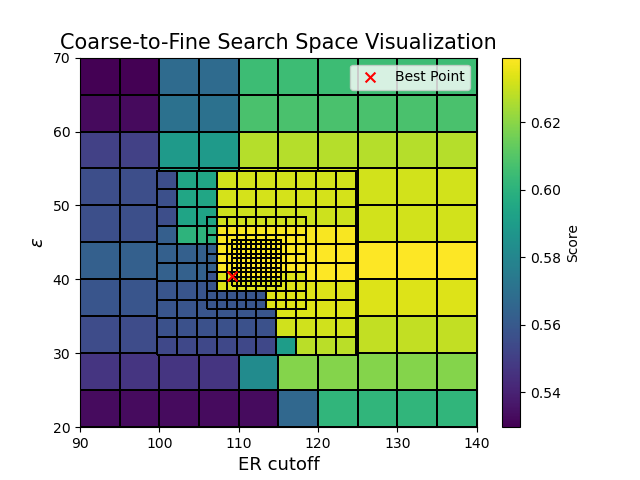

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def multi_scale_coarse_to_fine(objective_func, param1_range, param2_range, levels=3, num_points=10, refinement_factor=2):
    """
    Performs a multi-scale coarse-to-fine grid search with visualization, using a fixed number of grid points per level.
    
    Parameters:
    - objective_func: Callable function to evaluate, takes param1 and param2 and returns a score.
    - param1_range: Tuple (min, max) for the first parameter.
    - param2_range: Tuple (min, max) for the second parameter.
    - levels: Number of refinement levels.
    - num_points: Number of grid points per dimension at each level.
    - refinement_factor: Factor by which range size is reduced at each level.
    
    Returns:
    - best_combination: Tuple of best parameter values found.
    - max_score: Best score achieved.
    - history: List of search results at each level.
    - total_extent: Tuple defining the full extent of the search space.
    - global_min_score, global_max_score: Minimum and maximum scores across all levels for consistent colormap.
    """
    best_combination = None
    max_score = float('-inf')
    history = []
    global_min_score = float('inf')
    global_max_score = float('-inf')
    
    # Track the total extent of the search space across all levels
    total_extent = [param1_range[0], param1_range[1], param2_range[0], param2_range[1]]
    
    current_param1_range = param1_range
    current_param2_range = param2_range

    for level in range(levels):
        # Calculate grid points for the current range and number of points
        param1_values = np.linspace(current_param1_range[0], current_param1_range[1], num_points)
        param2_values = np.linspace(current_param2_range[0], current_param2_range[1], num_points)

        print("Now at level {}: \nSearch space = ({:.2f},{:.2f})x({:.2f},{:.2f})".format(level, current_param1_range[0], current_param1_range[1],
                                                                          current_param2_range[0], current_param2_range[1]))
        score_grid = np.zeros((len(param1_values), len(param2_values)))
        
        # Coarse-to-fine grid search at current level
        for i, param1 in enumerate(param1_values):
            for j, param2 in enumerate(param2_values):
                score = objective_func(param1, param2)[1]  # Assume objective_func returns a tuple with score at index 1
                score_grid[i, j] = score

                # Track the global min and max score for consistent colormap
                global_min_score = min(global_min_score, score)
                global_max_score = max(global_max_score, score)

                # Update the best score and combination
                if score > max_score:
                    max_score = score
                    best_combination = (param1, param2)

        # Save the results and shrink the range around the best combination
        history.append((param1_values, param2_values, score_grid))
        
        # Update total extent based on the current level's parameter ranges
        total_extent[0] = min(total_extent[0], current_param1_range[0])
        total_extent[1] = max(total_extent[1], current_param1_range[1])
        total_extent[2] = min(total_extent[2], current_param2_range[0])
        total_extent[3] = max(total_extent[3], current_param2_range[1])
        
        # Update ranges around the best combination for the next finer search
        best_param1, best_param2 = best_combination
        param1_range_span = (current_param1_range[1] - current_param1_range[0]) / refinement_factor
        param2_range_span = (current_param2_range[1] - current_param2_range[0]) / refinement_factor
        
        current_param1_range = (best_param1 - param1_range_span / 2, best_param1 + param1_range_span / 2)
        current_param2_range = (best_param2 - param2_range_span / 2, best_param2 + param2_range_span / 2)

    return best_combination, max_score, history, total_extent, global_min_score, global_max_score

def visualize_search_space(history, total_extent, global_min_score, global_max_score, best_combination):
    fig, ax = plt.subplots()
    
    # Plot each level of search with increasing transparency
    for level, (param1_values, param2_values, score_grid) in enumerate(history):
        # Define the boundaries of each cell for pcolormesh
        param1_edges = np.linspace(param1_values[0], param1_values[-1], len(param1_values) + 1)
        param2_edges = np.linspace(param2_values[0], param2_values[-1], len(param2_values) + 1)
        
        # Use pcolormesh for a grid with cell boundaries highlighted
        mesh = ax.pcolormesh(param1_edges, param2_edges, score_grid.T, shading='flat',
                             cmap='viridis', vmin=global_min_score, vmax=global_max_score,
                             edgecolor='k', linewidth=0.01)  # Edge color and line width for borders
    
    # Set the fixed overall extent to cover the entire search area
    ax.set_xlim(total_extent[0], total_extent[1])
    ax.set_ylim(total_extent[2], total_extent[3])
    
    # Plot the best combination point in red
    ax.scatter(best_combination[0], best_combination[1], color='red', s=50, marker='x', label="Best Point")
    
    # Label axes
    ax.set_xlabel("ER cutoff", fontsize=13)
    ax.set_ylabel(r"$\epsilon$", fontsize=13)
    plt.colorbar(mesh, ax=ax, label="Score")
    plt.title("Coarse-to-Fine Search Space Visualization", fontsize=15)
    plt.legend()
    plt.show()
# Perform multi-scale search for your case
param1_range = (90, 140)  # Range for "cutoff"
param2_range = (20, 70)  # Range for "eps"

best_combination, max_score, history, total_extent, global_min_score, global_max_score = multi_scale_coarse_to_fine(
    classify, param1_range, param2_range, levels=4, num_points=10, refinement_factor=2
)

print("Best Parameters:", best_combination)
print("Max Score:", max_score)

# Visualize the search space within the total extent
visualize_search_space(history, total_extent, global_min_score, global_max_score, best_combination)


### Experimenting with an alternative Bayesian method to find optimal parameters

In [46]:
# Define the objective function
def objective(params):
    cutoff, eps = params
    return -classify(cutoff, eps)[1]  # Minimize the negative of the score

# Define the parameter space for Bayesian optimization
param_space = [Real(90, 140 , name="cutoff"), Real(20, 70, name="eps")]

# Setup tqdm progress bar
n_calls = 400  # Total number of iterations for the optimization
pbar = tqdm(total=n_calls, desc="Bayesian Optimization Progress")

# Define a callback function to update tqdm
def update_progress(res):
    pbar.update(1)

# Run Bayesian optimization with the callback
result = gp_minimize(objective, param_space, n_calls=n_calls, random_state=0, callback=[update_progress])

# Close the progress bar
pbar.close()

# Output the best parameters and score
best_params = result.x
best_score = -result.fun
print("Best combination:", best_params)
print("Best score:", best_score)



Bayesian Optimization Progress: 100%|█████████████████████████████████████████████████| 400/400 [17:04<00:00,  2.56s/it]

Best combination: [123.93565033081043, 40.42724947624628]
Best score: 0.6392172462120077


### Final classification plot and results

0.6392172462120081
     key     path        MER         VAR       area  label
     NLM    IGR-I   3.913990    0.288333   1.783879      0
     NLM   IGR-II   4.806850    0.265248   1.755251      0
     NLM  IGR-III   7.618343    0.710279   1.745533      0
     NLM   IGR-IV 274.676940 3085.484126  76.118420     -1
     NLM   IGR-IX   6.230152    0.854174   2.253135      0
     NLM    IGR-V 121.121718  499.360724  20.960686     -1
     NLM   IGR-VI 210.835752 5649.198720 135.667049     -1
     NLM  IGR-VII 287.175135 3583.003427  37.329801     -1
     NLM IGR-VIII 141.434892  326.227445   9.583112     -1
adaptive    IGR-I  46.545913   28.637761   4.507736      0
adaptive   IGR-II 102.977206   34.242807   4.438512      0
adaptive  IGR-III  24.344104   10.523421   3.550678      0
adaptive   IGR-IV  61.530187   61.136316   6.124498      0
adaptive   IGR-IX  17.946479   11.483616   4.301191      0
adaptive    IGR-V 151.295645  639.404178  15.545164     -1
adaptive   IGR-VI  72.197849   58.338

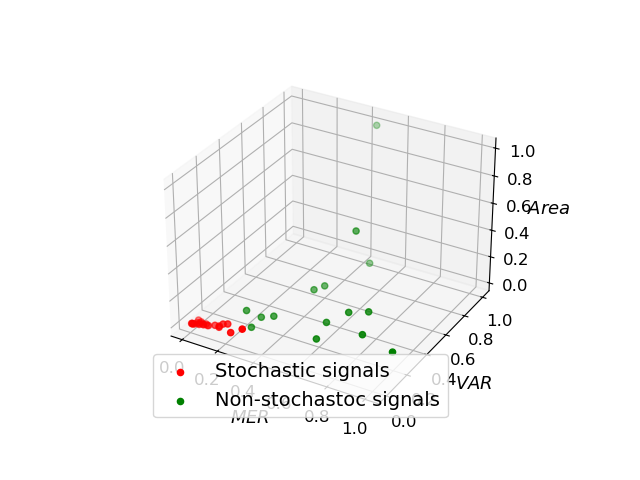

In [46]:
df, score = classify(123.93565033081043, 40.42724947624628)

print(score)
df=df.sort_values(by=['key',"path"])
#df.to_csv('/home/anindya/PCA.csv', index=False)
print(df.to_string(index=False))
df_out = df[df["label"]==-1]
df_in = df[df["label"]==0]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
#ax.scatter3D(np.log10(df_in["MER"]), np.log10(df_in["VAR"]), np.log10(df_in["area"]), color = "r")
#ax.scatter3D(np.log10(df_out["MER"]), np.log10(df_out["VAR"]), np.log10(df_out["area"]), color = "g")
ax.scatter3D((df_in["MER"]/max(df_out["MER"])), (df_in["VAR"])/max(df_out["VAR"]), (df_in["area"])/max(df_out["area"]), 
             color = "r", label = "Stochastic signals")
ax.scatter3D((df_out["MER"]/max(df_out["MER"])), (df_out["VAR"])/max(df_out["VAR"]) ,(df_out["area"])/max(df_out["area"]), 
             color = "g", label = "Non-stochastoc signals")
# ax.scatter3D((df_in["MER"]), (df_in["VAR"]), (df_in["area"]), color = "r", label = "Stochastic signals")
# ax.scatter3D((df_out["MER"]), (df_out["VAR"]) ,(df_out["area"]), color = "g", label = "Non-stochastoc signals")
ax.legend(loc = 'best')
ax.set_xlabel(r"$MER$", fontsize = 13)
ax.set_ylabel(r"$VAR$", fontsize = 13)
ax.zaxis.set_rotate_label(False)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.xaxis._axinfo['label']['space_factor'] = 0.0
ax.set_zlabel(r"$Area$", fontsize = 13,rotation = 0)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
plt.show()

## SVD testing and plots

In [ ]:
'''
SINGULAR VALUE DECOMPOSITION METHOD
'''

def SVD_E1_E2_plot(path, filter_typ, Embedding_Dim=None, delay=None):
    data = data_dict[path][filter_typ]
    data_unit_variate = (data - np.average(data)) / np.std(data)
    
    if delay is None:
        delay, _ = nk.complexity_delay(data_unit_variate, delay_max=1000, show=False,
                                       method="rosenstein1993")
    print("Delay calculated=", delay)
    
    if Embedding_Dim is None:
        Embedding_Dim, _ = nk.complexity_dimension(data_unit_variate, delay, dimension_max=25,
                                                   method="afnn", show=False)
    print("Optimal embedding dimension=", Embedding_Dim)
        
    Data_matrix = utils.reconstruct(data_unit_variate, Embedding_Dim, delay)
    u, s, vh = np.linalg.svd(Data_matrix.T, full_matrices=True)
    print(u.shape, s.shape, vh.shape)    
    return vh[::-1, 0], vh[::-1, 1], delay, Embedding_Dim


#########################################################################################

In [ ]:
# Directory for saving SVD plots
directory_name = "SVD_final_plots"
# keys=("NLM","boxcar","gaussian","adaptive","original",)
keys = ("adaptive",)

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"Directory '{directory_name}' created.")
else:
    print(f"Directory '{directory_name}' already exists.")

for key in keys:
    for i in range(1, 10):
        path = "IGR-{}".format(rom(i))
        
        # Calling the SVD  function defined earlier         
        x, y, delay, Embedding_Dim = SVD_E1_E2_plot(path, key)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
        
        fig.suptitle("SVD of " + path + " (filter= " + key + ")", fontsize=18)
        
        # Step 1: Density Estimation and Filtering Low-Density Outliear Points
        values = np.vstack([x, y])
        kde = gaussian_kde(values)
        densities = kde(values)
        density_cutoff = np.percentile(densities, 5) # Removing the bottom 5th percentile.
        mask = densities >= density_cutoff
        x = x[mask]
        y = y[mask]        
        
        # Panel 1: Gradient Line Plot
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        cmap = cm.viridis
        colors = cmap(np.linspace(0, 1, len(x) - 1))
        lc = LineCollection(segments, colors=colors, linewidth=0.3)
        ax1.add_collection(lc)
        
        ax1.set_xlim(1.2 * x.min(), 1.2 * x.max())
        ax1.set_ylim(1.2 * y.min(), 1.2 * y.max())
        # ax1.set_xlabel("E1 (delay=" + str(delay) + " dim=" + str(Embedding_Dim) + ")")
        # ax1.set_ylabel("E2")
        ax1.set_title("Gradient Line Plot", fontsize = 16)
        
        # Panel 2: Density Contour Plot with Local Maxima
        sns.kdeplot(x=x, y=y, ax=ax2, cmap="Blues", fill=True, thresh=0.1, levels=30)
        
        # Generate 2D KDE on a grid
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        xx, yy = np.meshgrid(np.linspace(xmin, xmax, 1000), np.linspace(ymin, ymax, 1000))
        positions = np.vstack([xx.ravel(), yy.ravel()])
        kde = gaussian_kde(values)
        density = kde(positions).reshape(xx.shape)
        
        # Step 2: Apply Density Threshold and Find Peaks Using peak_local_max
        density_threshold = np.percentile(density, 50)  # Threshold at 50th percentile
        min_distance = 1  # Minimum distance between peaks

        # Find peaks in the 2D density map
        peaks = peak_local_max(density, min_distance=min_distance, threshold_rel = 0.05)

        # Add contour line at the density threshold level
        sns.kdeplot(x=x, y=y, ax=ax2, levels=[density_threshold / density.max()], colors="black", linewidths=1.5)
        
        # Mark detected peaks on the contour plot
        # significant_peaks = [peak for peak in peaks if density_smoothed[peak[0], peak[1]] > density_threshold]
        for peak in peaks:
            peak_x, peak_y = xx[0, peak[1]], yy[peak[0], 0]
            ax2.plot(peak_x, peak_y, 'ro', markersize=5)  # Red dots for significant peaks
        
        
        ax2.set_xlim(1.2 * x.min(), 1.2 * x.max())
        ax2.set_ylim(1.2 * y.min(), 1.2 * y.max())
        # ax2.set_xlabel("E1")
        # ax2.set_ylabel("E2", )
        ax2.set_title("Density Contour Plot with Local Maxima", fontsize = 16)
        black_contour_proxy = mlines.Line2D([], [], color='black', linewidth=1.5, label='Median density Contour')
        red_dots_proxy = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='Density maximas')

        # Add the legend to ax2 with proxy artists
        ax2.legend(handles=[black_contour_proxy, red_dots_proxy], loc='best', fontsize=13)

        fig.supxlabel("E1 (delay=" + str(delay) + " dim=" + str(Embedding_Dim) + ")", fontsize=14)
        fig.supylabel("E2", fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig("./{}/".format(directory_name) + path + "(filter= " + key + ")" + ".png", format = "png")
        plt.show()